# 01 — Exploratory Data Analysis: OHLCV Price Data

**Goal:** Understand the dataset before building any ML models.

We'll cover:
1. Loading data from our silver layer (parquet) and DuckDB
2. Shape, dtypes, missing values
3. Price distributions and summary statistics
4. Time-series plots per symbol
5. Daily returns — distribution and volatility
6. Correlation between stocks
7. Volume analysis
8. Key takeaways for feature engineering

In [1]:
import sys
sys.path.insert(0, "..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb

sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (14, 5)
plt.rcParams["figure.dpi"] = 100

print("Libraries loaded.")

Libraries loaded.


## 1. Load Data

Two ways to access our data — direct parquet read, or via DuckDB SQL.
We'll use both so you get comfortable with each approach.

In [2]:
# Method 1: Direct parquet read
ohlcv = pd.read_parquet("ohlcv_daily.parquet")
dim_assets = pd.read_parquet("dim_assets.parquet")

print(f"OHLCV rows: {len(ohlcv):,}")
print(f"Assets: {len(dim_assets)}")
print(f"Symbols: {sorted(ohlcv['symbol'].unique())}")
print(f"Date range: {ohlcv['ts'].min()} to {ohlcv['ts'].max()}")

OHLCV rows: 89,719
Assets: 10
Symbols: ['AAPL', 'AMZN', 'GOOGL', 'JNJ', 'JPM', 'META', 'MSFT', 'NVDA', 'TSLA', 'XOM']
Date range: 1970-01-02 00:00:00 to 2026-02-06 00:00:00


## 2. Data Quality Check

Before any analysis — always check for nulls, dtypes, and anomalies.

In [4]:
print("=== Data Types ===")
print(ohlcv.dtypes)
print()

print("=== Missing Values ===")
print(ohlcv.isnull().sum())
print()

print("=== Duplicates ===")
dupes = ohlcv.duplicated(subset=["source", "symbol", "ts"]).sum()
print(f"Duplicate rows (source, symbol, ts): {dupes}")
print()

print("=== Sample Rows ===")
ohlcv.head(10)

=== Data Types ===
source                      object
symbol                      object
ts                  datetime64[ns]
open                       float64
high                       float64
low                        float64
close                      float64
volume                     float64
ingested_at    datetime64[us, UTC]
dtype: object

=== Missing Values ===
source         0
symbol         0
ts             0
open           0
high           0
low            0
close          0
volume         0
ingested_at    0
dtype: int64

=== Duplicates ===
Duplicate rows (source, symbol, ts): 0

=== Sample Rows ===


,source,symbol,ts,open,high,low,close,volume,ingested_at
0,stooq,AAPL,1984-09-07,0.099265,0.100484,0.098067,0.099265,99149603.0,2026-02-08 23:08:15.320637+00:00
1,stooq,AAPL,1984-09-10,0.099265,0.099570,0.096879,0.098676,76956267.0,2026-02-08 23:08:15.320637+00:00
2,stooq,AAPL,1984-09-11,0.099570,0.102271,0.099570,0.100484,181467446.0,2026-02-08 23:08:15.320637+00:00
3,stooq,AAPL,1984-09-12,0.100484,0.101071,0.097458,0.097458,158527291.0,2026-02-08 23:08:15.320637+00:00
4,stooq,AAPL,1984-09-13,0.102880,0.103173,0.102880,0.102880,246900394.0,2026-02-08 23:08:15.320637+00:00
5,stooq,AAPL,1984-09-14,0.103173,0.106760,0.103173,0.104363,293981051.0,2026-02-08 23:08:15.320637+00:00
6,stooq,AAPL,1984-09-17,0.107073,0.108567,0.107073,0.107073,229535149.0,2026-02-08 23:08:15.320637+00:00
7,stooq,AAPL,1984-09-18,0.107073,0.107957,0.103173,0.103173,115874598.0,2026-02-08 23:08:15.320637+00:00
8,stooq,AAPL,1984-09-19,0.103173,0.104363,0.101071,0.101071,126571111.0,2026-02-08 23:08:15.320637+00:00
9,stooq,AAPL,1984-09-20,0.101368,0.102271,0.101368,0.101368,78796873.0,2026-02-08 23:08:15.320637+00:00


In [5]:
# Check for zero or negative prices (data quality red flags)
for col in ["open", "high", "low", "close"]:
    bad = (ohlcv[col] <= 0).sum()
    if bad > 0:
        print(f"WARNING: {bad} rows with {col} <= 0")

# Check OHLC consistency: high >= low, high >= open, high >= close
inconsistent = ohlcv[ohlcv["high"] < ohlcv["low"]]
print(f"Rows where high < low: {len(inconsistent)}")

# Check for zero volume days
zero_vol = ohlcv[ohlcv["volume"] == 0]
print(f"Zero-volume days: {len(zero_vol)}")

Rows where high < low: 0
Zero-volume days: 8


## 3. Summary Statistics

Get a feel for the scale and distribution of each stock.

In [6]:
summary = ohlcv.groupby("symbol")["close"].describe().round(2)
summary

,count,mean,std,min,25%,50%,75%,max
symbol,,,,,,,,
AAPL,10435.0,31.05,60.73,0.05,0.29,1.21,24.91,286.19
AMZN,7222.0,46.64,65.52,0.07,2.16,9.64,85.79,254.00
GOOGL,5402.0,56.59,60.42,2.49,13.33,29.56,77.23,343.69
JNJ,14143.0,42.04,52.08,0.33,1.30,22.33,48.38,239.99
JPM,14143.0,36.95,55.63,1.19,3.01,19.62,36.72,334.61
META,3450.0,224.09,181.82,17.73,96.08,173.00,293.22,790.00
MSFT,10052.0,68.44,116.70,0.06,4.30,20.82,46.29,542.07
NVDA,6802.0,14.20,37.07,0.03,0.26,0.45,5.69,207.04
TSLA,3927.0,101.29,127.69,1.05,12.86,20.06,210.44,489.88


## 4. Price Time Series

Visualize closing prices over time. This immediately reveals trends, crashes, and regime changes.

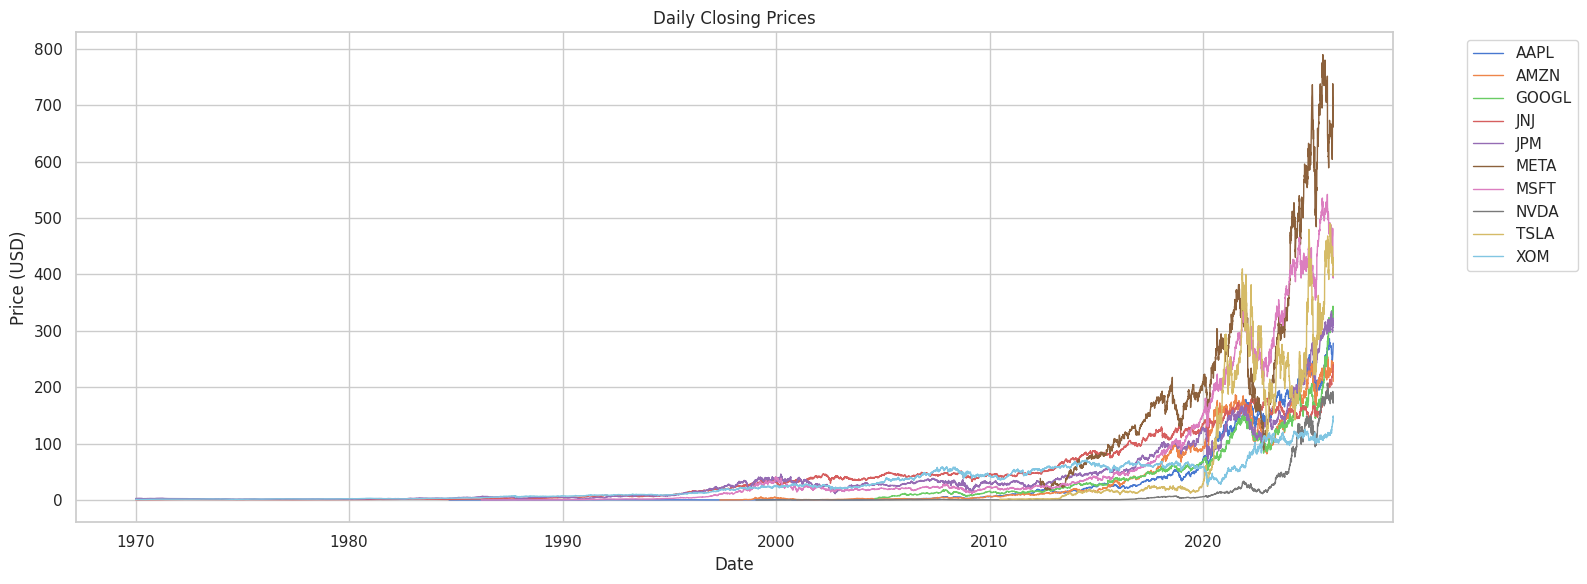

In [7]:
fig, ax = plt.subplots(figsize=(16, 6))

for sym in sorted(ohlcv["symbol"].unique()):
    subset = ohlcv[ohlcv["symbol"] == sym].sort_values("ts")
    ax.plot(subset["ts"], subset["close"], label=sym, linewidth=1)

ax.set_title("Daily Closing Prices")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

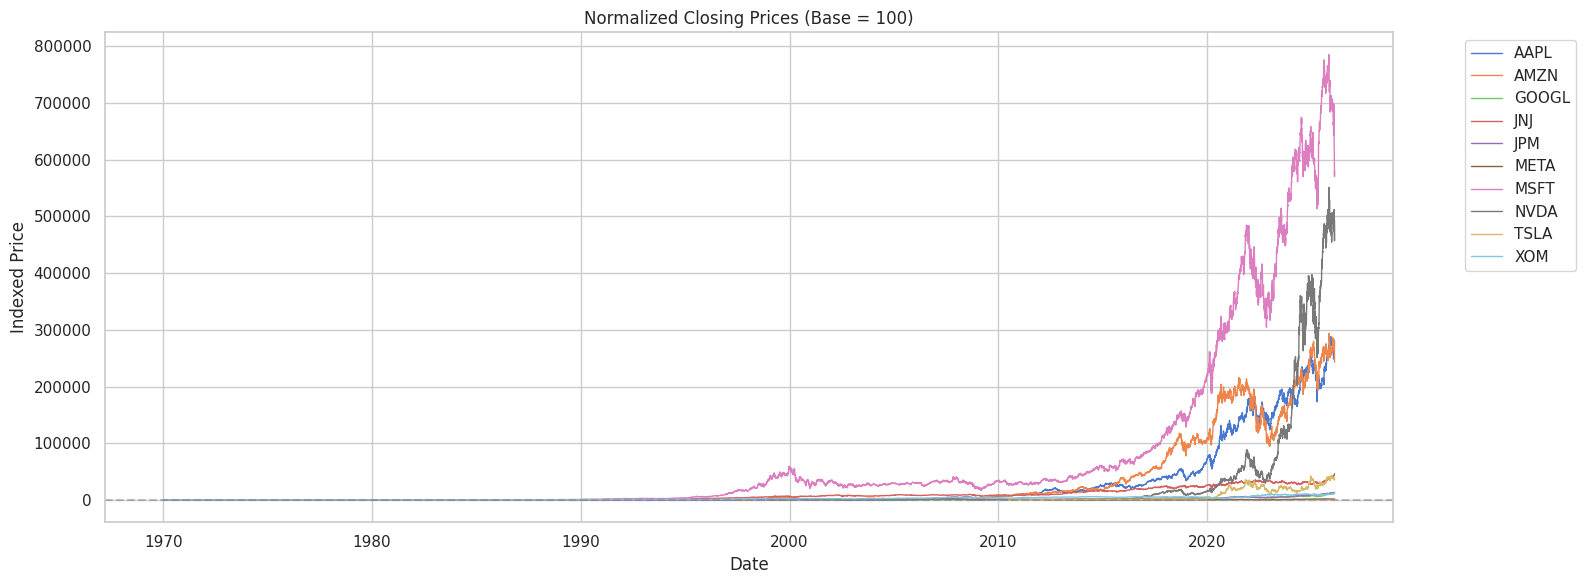

In [8]:
# Normalized prices (base 100) — easier to compare performance
fig, ax = plt.subplots(figsize=(16, 6))

for sym in sorted(ohlcv["symbol"].unique()):
    subset = ohlcv[ohlcv["symbol"] == sym].sort_values("ts")
    normalized = (subset["close"] / subset["close"].iloc[0]) * 100
    ax.plot(subset["ts"], normalized, label=sym, linewidth=1)

ax.set_title("Normalized Closing Prices (Base = 100)")
ax.set_xlabel("Date")
ax.set_ylabel("Indexed Price")
ax.axhline(y=100, color="gray", linestyle="--", alpha=0.5)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## 5. Daily Returns Analysis



In [9]:
# Calculate daily returns per symbol
ohlcv = ohlcv.sort_values(["symbol", "ts"])
ohlcv["daily_return"] = ohlcv.groupby("symbol")["close"].pct_change()

# Drop first row per symbol (NaN return)
returns_df = ohlcv.dropna(subset=["daily_return"])

returns_df.groupby("symbol")["daily_return"].describe().round(4)

,count,mean,std,min,25%,50%,75%,max
symbol,,,,,,,,
AAPL,10434.0,0.0011,0.0268,-0.5185,-0.0119,0.0002,0.0139,0.3325
AMZN,7221.0,0.0017,0.0348,-0.2477,-0.0129,0.0004,0.0146,0.3447
GOOGL,5401.0,0.0011,0.0193,-0.1163,-0.0080,0.0009,0.0103,0.1999
JNJ,14142.0,0.0005,0.0144,-0.1838,-0.0072,0.0000,0.0079,0.1223
JPM,14142.0,0.0006,0.0210,-0.2768,-0.0091,0.0000,0.0099,0.2512
META,3449.0,0.0011,0.0250,-0.2639,-0.0101,0.0010,0.0127,0.2961
MSFT,10051.0,0.0011,0.0220,-0.3000,-0.0087,0.0000,0.0107,0.1955
NVDA,6801.0,0.0020,0.0375,-0.3526,-0.0161,0.0013,0.0183,0.4250
TSLA,3926.0,0.0022,0.0369,-0.2106,-0.0165,0.0012,0.0196,0.4053


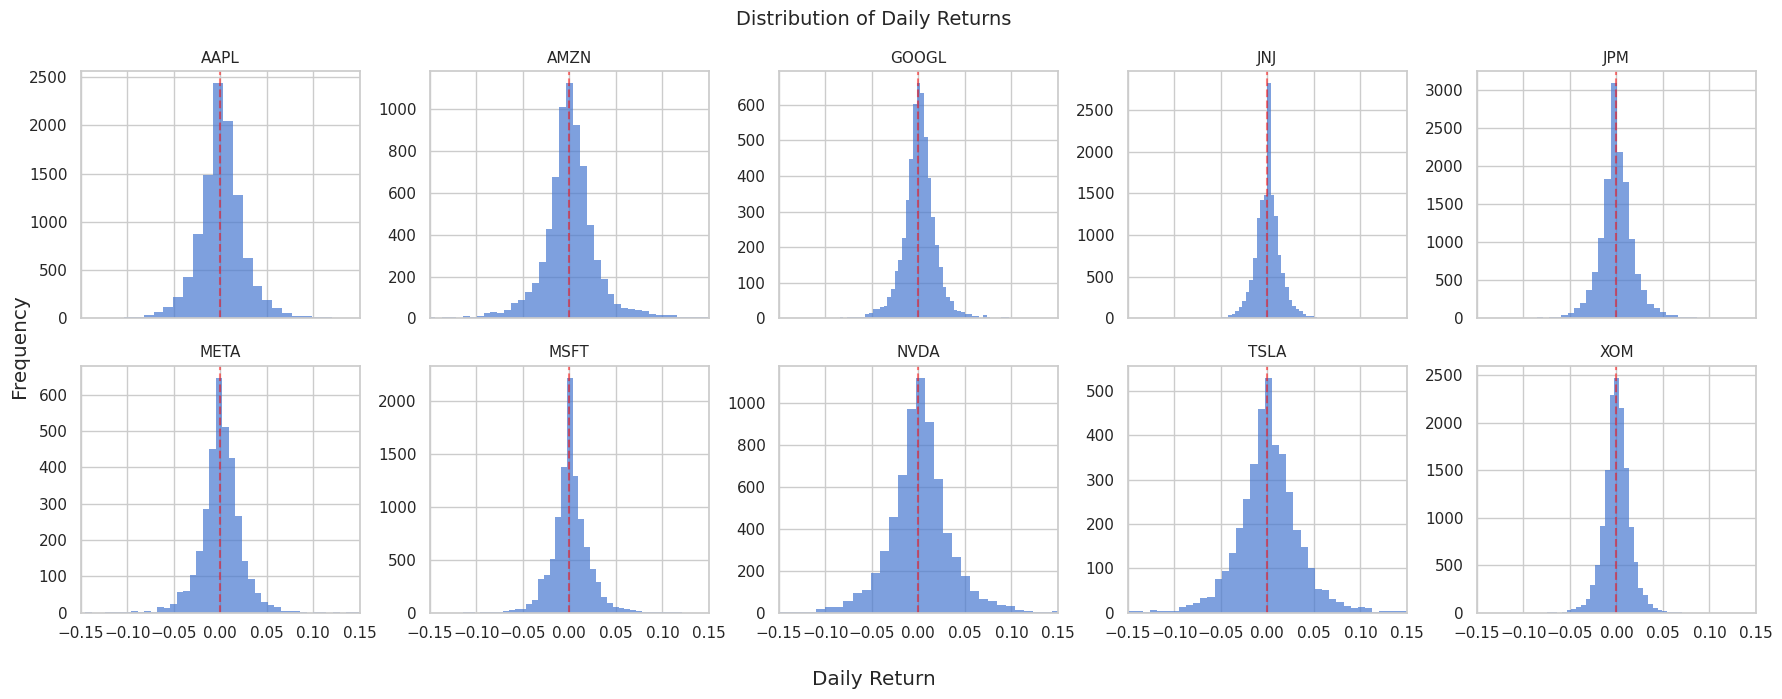

In [10]:
# Distribution of daily returns — are they normal?
fig, axes = plt.subplots(2, 5, figsize=(18, 7), sharex=True)

for ax, sym in zip(axes.flatten(), sorted(returns_df["symbol"].unique())):
    data = returns_df[returns_df["symbol"] == sym]["daily_return"]
    ax.hist(data, bins=80, edgecolor="none", alpha=0.7)
    ax.axvline(0, color="red", linestyle="--", alpha=0.5)
    ax.set_title(sym, fontsize=11)
    ax.set_xlim(-0.15, 0.15)

fig.suptitle("Distribution of Daily Returns", fontsize=14)
fig.supxlabel("Daily Return")
fig.supylabel("Frequency")
plt.tight_layout()
plt.show()

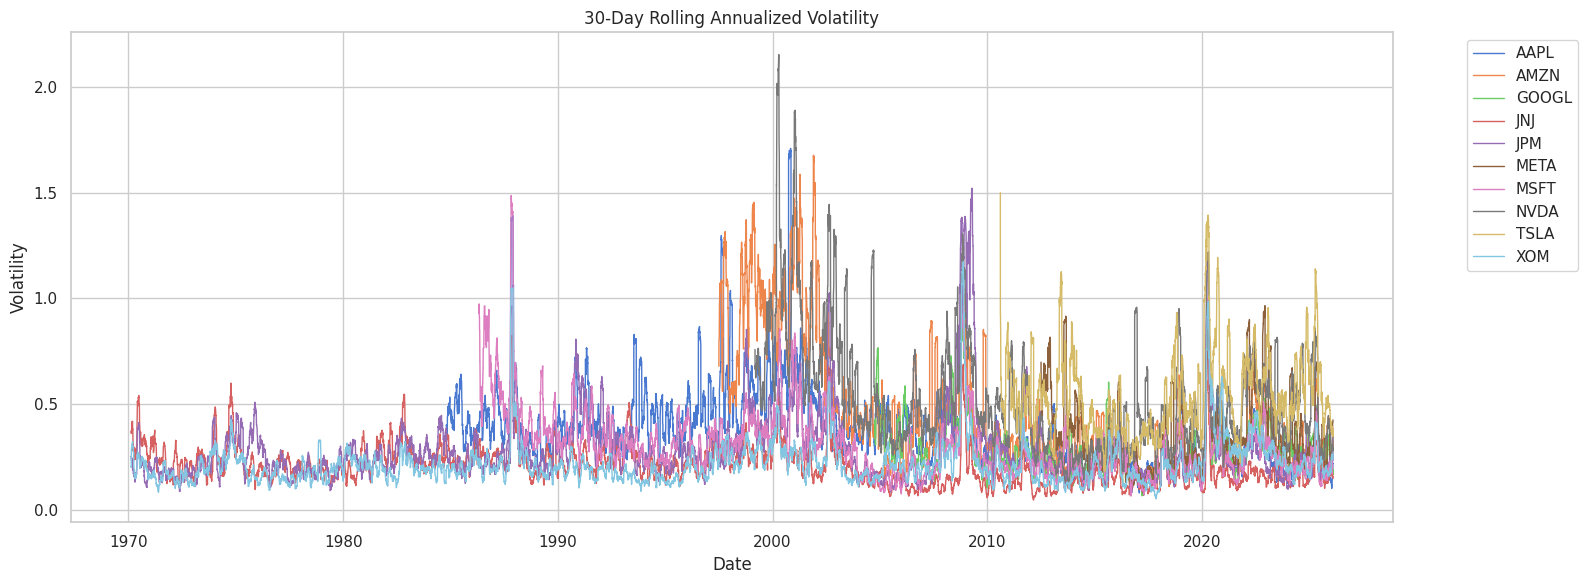

In [11]:
# Rolling 30-day volatility (std of returns)
fig, ax = plt.subplots(figsize=(16, 6))

for sym in sorted(returns_df["symbol"].unique()):
    subset = returns_df[returns_df["symbol"] == sym].sort_values("ts")
    rolling_vol = subset["daily_return"].rolling(30).std() * np.sqrt(252)  # annualized
    ax.plot(subset["ts"], rolling_vol, label=sym, linewidth=1)

ax.set_title("30-Day Rolling Annualized Volatility")
ax.set_xlabel("Date")
ax.set_ylabel("Volatility")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## 6. Correlation Analysis

How do these stocks move relative to each other? High correlation means they tend to move together.
This matters for:
- Portfolio diversification
- Feature selection (correlated features may be redundant)

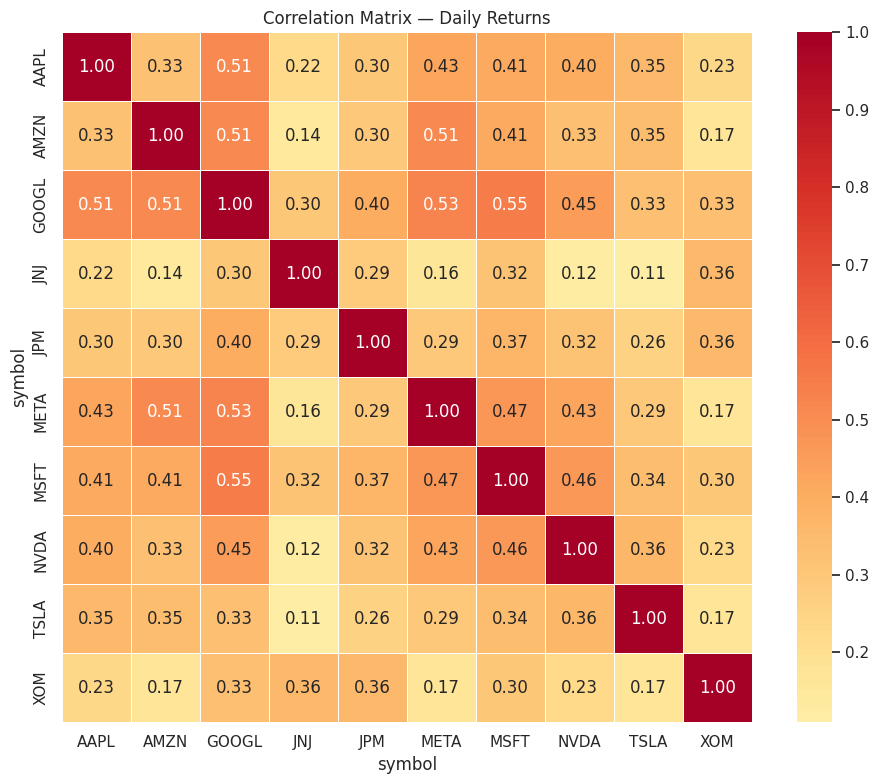

In [12]:
# Pivot returns into wide format: each column = one stock's daily return
returns_wide = returns_df.pivot_table(
    index="ts", columns="symbol", values="daily_return"
)

corr = returns_wide.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="RdYlBu_r",
    center=0,
    square=True,
    linewidths=0.5,
    ax=ax,
)
ax.set_title("Correlation Matrix — Daily Returns")
plt.tight_layout()
plt.show()

## 7. Volume Analysis

Volume confirms price moves — a price increase on high volume is more significant than on low volume.

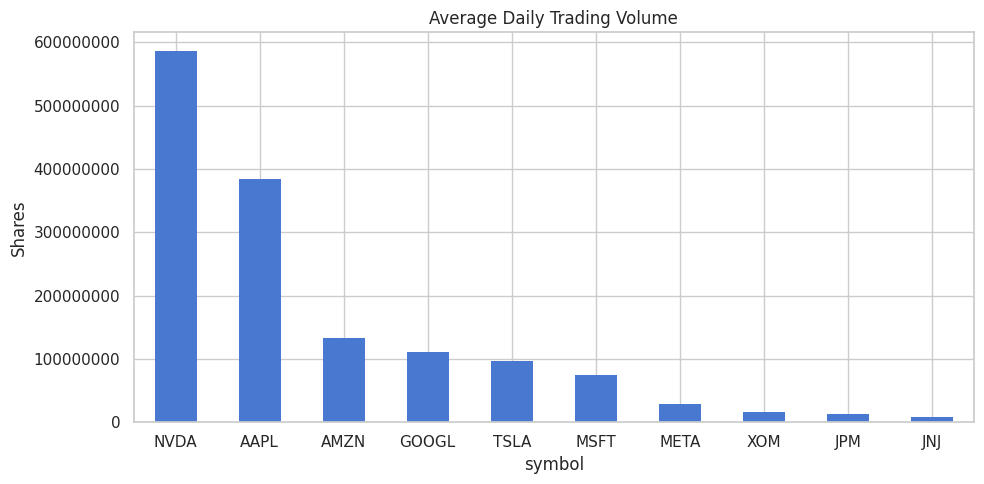

In [13]:
# Average daily volume by symbol
avg_vol = ohlcv.groupby("symbol")["volume"].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
avg_vol.plot(kind="bar", ax=ax, edgecolor="none")
ax.set_title("Average Daily Trading Volume")
ax.set_ylabel("Shares")
ax.ticklabel_format(axis="y", style="plain")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

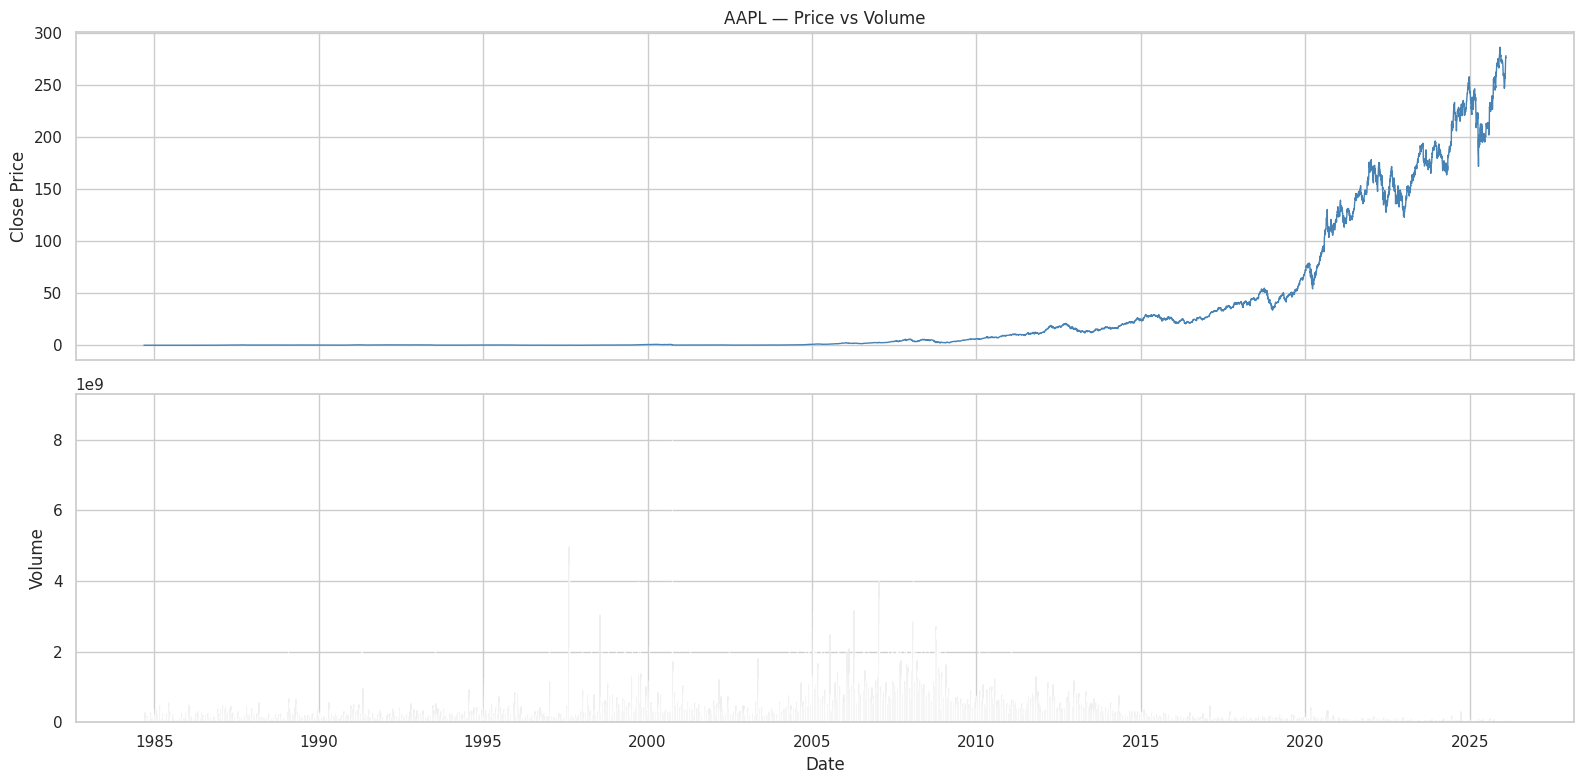

In [14]:
# Volume-price relationship for one stock (AAPL)
aapl = ohlcv[ohlcv["symbol"] == "AAPL"].sort_values("ts").copy()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

ax1.plot(aapl["ts"], aapl["close"], color="steelblue", linewidth=1)
ax1.set_ylabel("Close Price")
ax1.set_title("AAPL — Price vs Volume")

ax2.bar(aapl["ts"], aapl["volume"], color="gray", alpha=0.6, width=1)
ax2.set_ylabel("Volume")
ax2.set_xlabel("Date")

plt.tight_layout()
plt.show()

## 8. Candlestick-style OHLC View

Quick look at the spread between open/high/low/close.

In [16]:
# Intraday range as a % of close — how much does the stock move within a day?
ohlcv["intraday_range_pct"] = (ohlcv["high"] - ohlcv["low"]) / ohlcv["close"] * 100

range_stats = ohlcv.groupby("symbol")["intraday_range_pct"].agg(["mean", "median", "max"]).round(2)
range_stats.columns = ["mean_%", "median_%", "max_%"]
range_stats.sort_values("mean_%", ascending=False)

,mean_%,median_%,max_%
symbol,,,
TSLA,4.27,3.68,75.31
NVDA,4.24,3.44,36.76
AMZN,3.68,2.71,29.41
AAPL,3.08,2.59,34.88
META,2.65,2.31,18.44
MSFT,2.47,2.06,42.86
JPM,2.31,1.86,38.28
GOOGL,2.17,1.86,16.28
XOM,1.82,1.56,40.66


## 9. Key Takeaways

Run this after examining the outputs above — summarize what you observe.

Things to note:
- **Which stocks are most volatile?** (TSLA, NVDA likely)
- **Are returns normally distributed?** (Probably fat-tailed)
- **Which stocks are most correlated?** (Tech cluster likely)
- **Any data quality issues?** (Missing days, zero volume, etc.)
- **Date range coverage** — is it sufficient for training?

These observations will guide our feature engineering in the next notebook.

In [17]:
# Quick summary for reference
print("=== Dataset Summary ===")
print(f"Symbols: {sorted(ohlcv['symbol'].unique())}")
print(f"Total rows: {len(ohlcv):,}")
print(f"Date range: {ohlcv['ts'].min()} to {ohlcv['ts'].max()}")
print(f"Missing values: {ohlcv[['open','high','low','close','volume']].isnull().sum().sum()}")
print(f"\nMost volatile (avg daily return std):")
print(returns_df.groupby('symbol')['daily_return'].std().sort_values(ascending=False).head(3).round(4).to_string())
print(f"\nHighest avg volume:")
print(avg_vol.head(3).apply(lambda x: f"{x:,.0f}").to_string())

=== Dataset Summary ===
Symbols: ['AAPL', 'AMZN', 'GOOGL', 'JNJ', 'JPM', 'META', 'MSFT', 'NVDA', 'TSLA', 'XOM']
Total rows: 89,719
Date range: 1970-01-02 00:00:00 to 2026-02-06 00:00:00
Missing values: 0

Most volatile (avg daily return std):
symbol
NVDA    0.0375
TSLA    0.0369
AMZN    0.0348

Highest avg volume:
symbol
NVDA    586,336,766
AAPL    384,386,552
AMZN    132,421,024


---

**Next:** `02_feature_engineering.ipynb` — Build technical indicators (RSI, MACD, moving averages, Bollinger Bands) and prepare features for ML models.